In [344]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [578]:
data = pd.DataFrame(pd.read_excel("data.xlsm", sheet_name="weekly"))
data.dropna(inplace=True)

S1 = data["VNQ (closing)"].astype("float")
S2 = data["SPY (closing)"].astype("float")

# S1 = S1.pct_change()*100
# S2 = S2.pct_change()*100
# S1.dropna(inplace=True)
# S2.dropna(inplace=True)

,Date,VNQ (closing),SPY (closing)
1,2007-01-01,53.1,110.34
2,2007-01-08,46.85,88.5
3,2007-01-15,42.372,93.21
4,2007-01-22,35.19,87.04
5,2007-01-29,41.51,96.83
6,2007-02-05,38.75,93.86
7,2007-02-12,31.81,86.62
8,2007-02-19,25.99,79.52
9,2007-02-26,32.08,90.09
10,2007-03-05,33.22,87.93


0.17443937355658046 -1.1544590046063552 34.111180846429775
0.01110053056594066 -693.829323820064 784.3810149594412


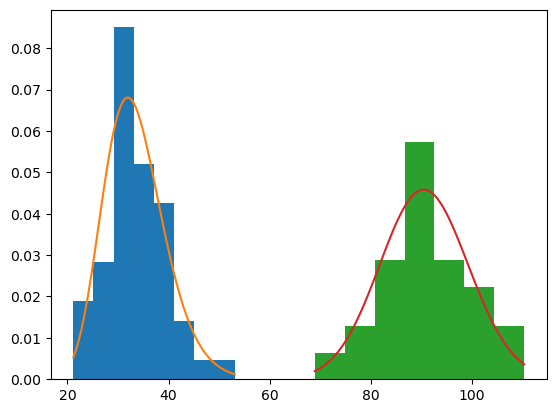

In [592]:
# mu = ln(scale), shape = sigma
S1_shape, S1_loc, S1_scale = stats.lognorm.fit(S1)
S2_shape, S2_loc, S2_scale = stats.lognorm.fit(S2)

x = np.linspace(min(S1), max(S1), 100)
plt.hist(S1, bins=8, density=True)
plt.plot(x, stats.lognorm.pdf(x, S1_shape, loc=S1_loc, scale=S1_scale))
print(S1_shape, S1_loc, S1_scale)

x = np.linspace(min(S2), max(S2), 100)
plt.hist(S2, bins=7, density=True)
plt.plot(x, stats.lognorm.pdf(x, S2_shape, loc=S2_loc, scale=S2_scale))
print(S2_shape, S2_loc, S2_scale)

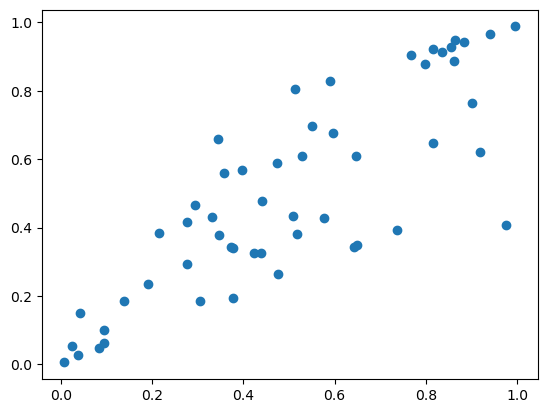

In [590]:
S1_CDF = stats.lognorm.cdf(S1, S1_shape, loc=S1_loc, scale=S1_scale)
S2_CDF = stats.lognorm.cdf(S2, S2_shape, loc=S2_loc, scale=S2_scale)
plt.scatter(S1_CDF, S2_CDF)

In [596]:
rho, p = stats.pearsonr(S1_CDF, S2_CDF)
print(pearsonr, p)

0.8305922714576357 1.4351930847576213e-14


In [617]:
from scipy.optimize import minimize
import statsmodels.distributions.copula.api as sm

# Fixed value of rho (correlation)
rho_fixed = rho  # Replace with your fixed value of rho

# Define the log-likelihood function for the bivariate t-copula with fixed rho
def bivariate_t_copula_log_likelihood_nu(params, data, rho_fixed):
    nu = params[0]  # Only estimating nu
    # Create the bivariate t-copula using statsmodels with fixed rho
    copula = sm.StudentTCopula(np.array([[1, rho_fixed], [rho_fixed, 1]]), df=nu)
    
    # Evaluate the log-likelihood
    u = np.array(data)
    log_likelihood = np.sum(copula.logpdf(u))  # Log of the joint PDF
    return -log_likelihood  # Minimize the negative log-likelihood

# Initial guess for nu
initial_nu = 4
bounds_nu = [(1, 100)]  # Bounds for nu

df = pd.DataFrame({'u':S1_CDF, 'v':S2_CDF})

# Perform the optimization using minimize
result = minimize(bivariate_t_copula_log_likelihood_nu, [initial_nu], args=(df, rho_fixed),
                  bounds=bounds_nu, method='L-BFGS-B')

# Extract the estimated nu
nu_estimated = result.x[0]
print("Estimated Degrees of Freedom (nu):", nu_estimated)

Estimated Degrees of Freedom (nu): 3.829939833890225
